# Generating useful features for further analysis on Amazon reviews

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [1]:
%matplotlib inline

In [2]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
#movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 9.49 s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [3]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [4]:
print(len(movies_tv))
print(movies_tv.head(5))

1697533
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [3]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

Wall time: 457 ms


In [4]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


In [11]:
instant_video.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime,Y_helpful,N_helpful
0,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,2014-05-03,0,0
1,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,2012-09-03,0,0
2,"[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,2013-10-16,0,1
3,"[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,2013-10-30,0,0
4,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,2009-02-11,1,1


### Exercise 1:

#### 1.1

Plot histograms of all numeric quantities. Do you notice anything interesting about them?

**Answer.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016B0B0BFD00>,
      dtype=object)

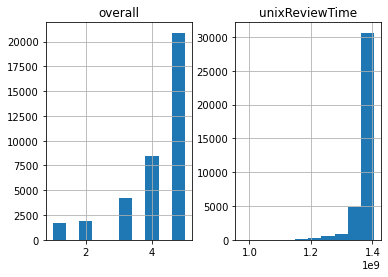

In [15]:
instant_video.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016B0A936670>,
      dtype=object)

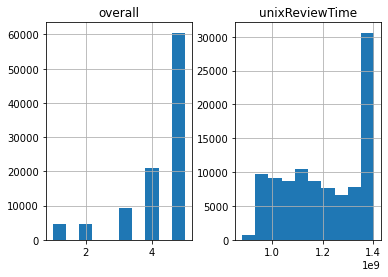

In [12]:
movies_tv.hist()

--------

#### 1.2

How do average ratings change over time? Plot the average rating for each year and note any trends.

**Answer.**

In [19]:
instant_video["year"]=instant_video["datetime"].apply(lambda x: x.year)
movies_tv["year"]=movies_tv["datetime"].apply(lambda x: x.year)
group1=instant_video.groupby("year").mean().reset_index()
group2=movies_tv.groupby("year").mean().reset_index()


In [26]:
from matplotlib.pyplot import figure

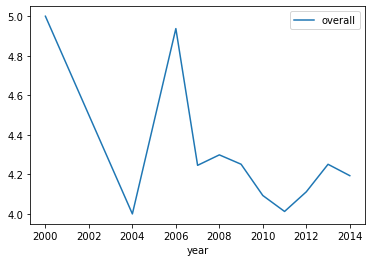

In [20]:
group1.plot.line(x="year",y="overall")

<Figure size 720x288 with 0 Axes>

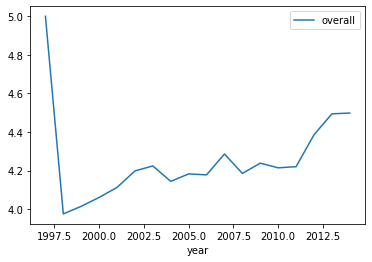

In [28]:
figure(figsize=(10,4))
group2.plot.line(x="year",y="overall")

--------

#### 1.3

Look at the average length of the review by year. Do you notice any trends?

**Answer.**

In [29]:
instant_video["review_words_lengths"] = instant_video["reviewText"].apply(lambda x: len(nltk.word_tokenize(x)))

In [30]:
%%time
movies_tv["review_words_lengths"] = movies_tv["reviewText"].apply(lambda x: len(nltk.word_tokenize(x)))

Wall time: 3min 47s


In [31]:
group1=instant_video.groupby("year").mean().reset_index()
group2=movies_tv.groupby("year").mean().reset_index()

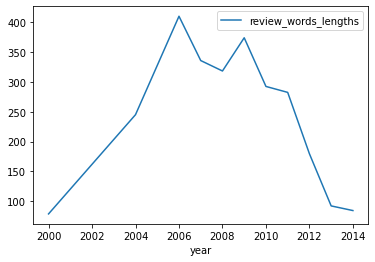

In [32]:
group1.plot.line(x="year",y="review_words_lengths")

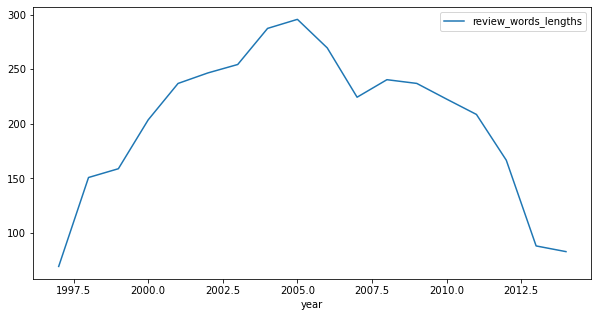

In [38]:

group2.plot.line(x="year",y="review_words_lengths",figsize=(10,5))


It seems that there was a tendency to write long reviews between 2004 and 2010, after this range shorter reviews became more normal

--------

### Exercise 2:

#### 2.1

Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

**Answer.**

In [5]:
from nltk.corpus import stopwords
from collections import Counter
import re

In [6]:
stop_words = set(stopwords.words("english"))

In [61]:
### Getting a single string from all reviews
all_reviews_text = ' '.join(instant_video["reviewText"])

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in stop_words and (re.compile("[@_!#$%^&*()<>?/\|}{~:.']").search(each.lower()) == None) and len(each.lower()) > 2]


word_freq = Counter(word_tokens_clean)

word_freq.most_common(10)

[('show', 24576),
 ('like', 13950),
 ('season', 13105),
 ('one', 12966),
 ('series', 12254),
 ('good', 11132),
 ('really', 8478),
 ('watch', 8424),
 ('great', 8414),
 ('characters', 8383)]

In [7]:
### Getting a single string from good reviews
all_reviews_text = ' '.join(instant_video[instant_video['overall']>3]["reviewText"])

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in stop_words and (re.compile("[@_!#$%^&*()<>?/\|}{~:.']").search(each.lower()) == None) and len(each.lower()) > 2]


word_freq = Counter(word_tokens_clean)

WGR_IV=word_freq.most_common(10)
WGR_IV=[x[0] for x in WGR_IV]
WGR_IV

['show',
 'season',
 'series',
 'like',
 'one',
 'good',
 'great',
 'characters',
 'watch',
 'love']

In [8]:
### Getting a single string from bad reviews
all_reviews_text = ' '.join(instant_video[instant_video['overall']<3]["reviewText"])

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in stop_words and (re.compile("[@_!#$%^&*()<>?/\|}{~:.']").search(each.lower()) == None) and len(each.lower()) > 2]


word_freq = Counter(word_tokens_clean)

WBR_IV=word_freq.most_common(10)
WBR_IV=[x[0] for x in WBR_IV]
WBR_IV

['show',
 'like',
 'movie',
 'one',
 'would',
 'film',
 'really',
 'good',
 'get',
 'time']

In [64]:
### Getting a single string from all reviews
all_reviews_text = ' '.join(movies_tv["reviewText"])

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in stop_words and (re.compile("[@_!#$%^&*()<>?/\|}{~:.']").search(each.lower()) == None) and len(each.lower()) > 2]


word_freq = Counter(word_tokens_clean)

word_freq.most_common(10)

[('movie', 139076),
 ('film', 112667),
 ('one', 73506),
 ('like', 46052),
 ('quot', 44715),
 ('good', 40422),
 ('great', 40100),
 ('time', 35735),
 ('story', 33252),
 ('would', 32008)]

In [9]:
### Getting a single string from good reviews
all_reviews_text = ' '.join(movies_tv[movies_tv['overall']>3]["reviewText"])

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in stop_words and (re.compile("[@_!#$%^&*()<>?/\|}{~:.']").search(each.lower()) == None) and len(each.lower()) > 2]


word_freq = Counter(word_tokens_clean)

WGR_MT=word_freq.most_common(10)
WGR_MT=[x[0] for x in WGR_MT]
WGR_MT

['movie',
 'film',
 'one',
 'great',
 'quot',
 'like',
 'good',
 'time',
 'story',
 'would']

In [10]:
### Getting a single string from bad reviews
all_reviews_text = ' '.join(movies_tv[movies_tv['overall']<3]["reviewText"])

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in stop_words and (re.compile("[@_!#$%^&*()<>?/\|}{~:.']").search(each.lower()) == None) and len(each.lower()) > 2]


word_freq = Counter(word_tokens_clean)

WBR_MT=word_freq.most_common(10)
WBR_MT=[x[0] for x in WBR_MT]
WBR_MT

['movie',
 'film',
 'one',
 'like',
 'quot',
 'would',
 'good',
 'even',
 'really',
 'time']

In [11]:
WGR_MT=[x[0] for x in WGR_MT]
WBR_MT=[x[0] for x in WBR_MT]

--------

The most common words in all ranges are very similar, this complicates the analysis so we must take another approach to the problem

 #### 2.2

Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and *not* in good reviews. What are these words and are they surprising?

**Answer.**

In [75]:
WBR_IV_CLEAN=[x for x in WBR_IV if x not in WGR_IV]
WBR_IV_CLEAN

['movie', 'would', 'film', 'really', 'get', 'time']

In [12]:
WBR_MT_CLEAN=[x for x in WBR_MT if x not in WGR_MT]
WBR_MT_CLEAN

['even', 'really']

These words doesn´t really describe or represent a bad review, we should take another approach

--------

### Exercise 3:

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

**Answer.**

In [22]:
bad_reviews_containing_good_IV = [each for each in instant_video[instant_video['overall']<3]["reviewText"] if 'good' in each]
for review in bad_reviews_containing_good_IV[:10]:
    print(review)
    print("")

I watched this because the Brits usually do a good job with good production values, casting and story lines.  However, in this case it proved a waste of 5 hours. The writers, directors and editors should be ashamed to put their names in the credits.  Important things happen with no apparent reason and the watcher is left scratching his/her head wondering what was the point.  The American general is miscast and not believable.  Lots of clicking of computer keyboards for solutions that never seem to work out. The ending stinks!

You know the plot. Trashy kids being trashy. The &#34;good&#34; ones are the &#34;poor&#34; ones. The rich trashy kids are just &#34;bad&#34;. Another movie to help the retarded careers of this TV show's actors. They are all old and washed out. But they still try to be hip and cool with their texting and foul mouths, sex videos. Sorry if you can't route for the heroine of the movie it clearly isn't worth watching.

There's a scene in Misery where the author write

In [14]:
bad_reviews_containing_good_MT = [each for each in movies_tv[movies_tv['overall']<3]["reviewText"] if 'good' in each]
for review in bad_reviews_containing_good_MT[:10]:
    print(review)
    print("")

The acting was good, the story was correct, but naked backsides was not necessary.  Also the Potiphers wife did not need to be so very seductive of a naked Joseph. Not a Christian movie.  I felt that even though it was probably portrayed truthfully, Christans do not need to see so explicit a scene.  This should be rated PG 13 at least.

The DVD transfer is pretty good but the scene with Yukon discovering peppermint has been cut.It seems pretty odd to sell a DVD as a restored classic only to leave out the main thing that was to be restored!

ANOTHER American cultural icon from the 60's has beendeemed unacceptable by those who would prefer to seemalice where none exists.Not even Underdog can escape the slings and arrows ofthose with the same mentality as the book-burners of1930's Germany.Why do we allow such obvious Orwellian "Newsspeak" toedit our past? Come on... this IS a cartoon, for Pete'ssake, NOT some social/political statement.Nothing here needs to be edited or "cleaned up". Thes

We should look for important words in each sentence, and what these important words are related to.

--------

### Exercise 4:

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

**Answer.**

In [16]:
def next_word(sentence):
    post = re.findall(r'good.*', sentence)
    if (len(post) > 0):
        temp = re.split(r'\s',post[0])
        if (len(temp) > 1):
            return(temp[1])
        else:
            return('')
    else:
        return('')

In [23]:
#The first word after good
post_good = []
ind = 0
for sentence in bad_reviews_containing_good_IV:
    temp = next_word(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
Counter(nonempty).most_common(10)

[('but', 41),
 ('and', 27),
 ('as', 22),
 ('for', 13),
 ('thing', 13),
 ('at', 13),
 ('to', 11),
 ('the', 11),
 ('The', 10),
 ('show', 9)]

In [20]:
#The first word after good
post_good = []
ind = 0
for sentence in bad_reviews_containing_good_MT:
    temp = next_word(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
Counter(nonempty).most_common(10)

[('as', 113),
 ('and', 108),
 ('but', 95),
 ('movie', 67),
 ('thing', 64),
 ('job', 47),
 ('to', 40),
 ('in', 39),
 ('movie.', 34),
 ('about', 30)]

In [24]:
# The first word after "good" that is a noun or cardinal
def ExtractInteresting1(sentence, good=['CD','NN']):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k,v in nltk.pos_tag(words) if v in good]
    return(interesting)
def next_word1(sentence):
    post = re.findall(r'good.*', sentence)
    if (len(post) > 0):
        temp = ExtractInteresting1(post[0])
        if (len(temp) > 0):
            return(temp[0])
        else:
            return('')
    else:
        return('')

In [25]:
post_good = []
ind = 0
for sentence in bad_reviews_containing_good_IV:
    temp = next_word1(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
Counter(nonempty).most_common(10)

[('show', 34),
 ('movie', 27),
 ('story', 21),
 ('thing', 20),
 ('one', 17),
 ('job', 16),
 ('idea', 16),
 ('acting', 14),
 ('film', 12),
 ('season', 11)]

In [26]:
post_good = []
ind = 0
for sentence in bad_reviews_containing_good_MT:
    temp = next_word1(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
Counter(nonempty).most_common(10)

[('movie', 282),
 ('film', 100),
 ('thing', 83),
 ('one', 70),
 ('job', 66),
 ('idea', 46),
 ('acting', 46),
 ('story', 40),
 ('goodness', 37),
 ('quot', 36)]

In [27]:
# The last word before "good" that is a noun or cardinal
def ExtractInteresting2(sentence, good=['CD','NN']):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k,v in nltk.pos_tag(words) if v in good]
    return(interesting)
def next_word2(sentence):
    post = re.findall(r'.+good', sentence)
    if (len(post) > 0):
        temp = ExtractInteresting2(post[0])
        if (len(temp) > 0):
            return(temp[-1])
        else:
            return('')
    else:
        return('')

In [28]:
post_good = []
ind = 0
for sentence in bad_reviews_containing_good_IV:
    temp = next_word2(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
Counter(nonempty).most_common(10)

[('movie', 38),
 ('show', 31),
 ('acting', 25),
 ('one', 24),
 ('good', 17),
 ('34', 14),
 ('something', 14),
 ('writing', 11),
 ('film', 11),
 ('story', 11)]

In [29]:
post_good = []
ind = 0
for sentence in bad_reviews_containing_good_MT:
    temp = next_word2(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
Counter(nonempty).most_common(10)

[('movie', 299),
 ('film', 136),
 ('one', 78),
 ('good', 56),
 ('acting', 52),
 ('quot', 42),
 ('story', 36),
 ('plot', 32),
 ('music', 20),
 ('way', 20)]

--------

### Exercise 5:

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.

**Answer.**

In [32]:
# Following code grabbed from:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [34]:
get_top_n_words(instant_video[instant_video['overall']<3]["reviewText"],20,3)

[('don waste time', 43),
 ('really wanted like', 24),
 ('parental guide bomb', 14),
 ('big bang theory', 13),
 ('waste time money', 12),
 ('bad acting bad', 12),
 ('don waste money', 10),
 ('dvd distribution handled', 10),
 ('note following review', 10),
 ('following review contain', 10),
 ('reader prefers review', 10),
 ('prefers review entirely', 10),
 ('review entirely spoiler', 10),
 ('entirely spoiler free', 10),
 ('34 lost 34', 10),
 ('guide bomb sex', 10),
 ('really looking forward', 9),
 ('blah blah blah', 9),
 ('complete waste time', 9),
 ('bomb sex nudity', 9)]

In [33]:
get_top_n_words(movies_tv[movies_tv['overall']<3]["reviewText"],20,3)

[('nightmare elm street', 98),
 ('tommy lee jones', 89),
 ('don waste time', 80),
 ('texas chainsaw massacre', 63),
 ('don waste money', 59),
 ('waste time money', 50),
 ('blu ray version', 48),
 ('catherine zeta jones', 42),
 ('blu ray release', 39),
 ('doesn make sense', 38),
 ('blu ray player', 37),
 ('movies ve seen', 37),
 ('gus van sant', 36),
 ('didn like movie', 35),
 ('movie ve seen', 34),
 ('let just say', 32),
 ('dvd blu ray', 31),
 ('prairie home companion', 31),
 ('ve seen movie', 30),
 ('complete waste time', 30)]

In [35]:
get_top_n_words(instant_video[instant_video['overall']<3]["reviewText"],20,2)

[('waste time', 150),
 ('story line', 116),
 ('ve seen', 114),
 ('don know', 102),
 ('sci fi', 92),
 ('don think', 81),
 ('34 34', 79),
 ('looks like', 75),
 ('high school', 64),
 ('special effects', 63),
 ('don care', 63),
 ('felt like', 63),
 ('don waste', 60),
 ('main character', 60),
 ('wanted like', 57),
 ('don like', 56),
 ('year old', 52),
 ('really good', 52),
 ('worth watching', 51),
 ('low budget', 51)]

In [36]:
get_top_n_words(movies_tv[movies_tv['overall']<3]["reviewText"],20,2)

[('blu ray', 685),
 ('special effects', 557),
 ('ve seen', 450),
 ('movie just', 395),
 ('waste time', 385),
 ('don know', 384),
 ('quot quot', 303),
 ('good movie', 267),
 ('looks like', 252),
 ('like movie', 239),
 ('look like', 236),
 ('sci fi', 233),
 ('years ago', 203),
 ('year old', 201),
 ('movie like', 197),
 ('watch movie', 196),
 ('don think', 192),
 ('horror movie', 188),
 ('movie good', 184),
 ('bad movie', 180)]

--------

### Exercise 6:

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.

**Answer.**

In [56]:
import pandas as pd
from nltk.corpus import stopwords
#Important words it's a list of words
##Function still doesn't work properly when the same important word is more than one time in a short-sentence.
#s_type depends on the relation we are looking for between the important and the informative word
def inf_word(longsentence,important_words, s_type="NN"):
    sentences = nltk.sent_tokenize(longsentence)
    Inf_words=pd.DataFrame()
    stop_words = set(stopwords.words("english"))
    for word in important_words:
        
        informative_words=[]
        for s in sentences:
            posts=[]
            ## Splitting them into tokens
            word_tokens = nltk.word_tokenize(s)

            ## Removing the stopwords
            word_tokens_clean = [each for each in word_tokens if each.lower() not in stop_words ]
            
            s=(" ").join(word_tokens_clean)
            posts.append(re.findall(r'%s.*'%word, s))
            posts.append(re.findall(r'.+%s'%word, s))
            i=0
            posible_word=[]
            for post in posts:
                if len(post)>0:
                    if (len(nltk.word_tokenize(post[0])) > 1):
                        words = nltk.word_tokenize(post[0])
                        interesting2 = [k for k,v in nltk.pos_tag(words) if v in [s_type]] 
                        if len(interesting2)>0:
                            posible_word.append(interesting2[-i])    
                i=i+1
            if len(posible_word)>1:
                d1= (re.search(r'\b(%s)\b'%posible_word[0], s).span()[1])-(re.search(r'\b(%s)\b'%word, s).span()[0])      
                d2=(re.search(r'\b(%s)\b'%word, s).span()[1])-(re.search(r'\b(%s)\b'%posible_word[1], s).span()[0])
                if d1<d2:
                    informative_words.append(posible_word[0])
                else:
                    informative_words.append(posible_word[1])
            else:
                if len(posible_word)>0:
                    informative_words.append(posible_word[0])
        Inf_words[word]=informative_words
    return Inf_words
w2=inf_word("That movie was good, very long history, but an awful sound",["good","awful"])
w2

,good,awful
0,movie,sound


We locate the important word in the sentence and then we look before and adther for the informative words closest to the important word.

--------

### Exercise 7:

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

**Answer.**

--------

In [52]:
def adj_noun(sentence):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k,v in nltk.pos_tag(words) if v in ["JJ"]]
    if (len(interesting) > 0):
        adjt_nouns=[]
        for adj in interesting:
            post = re.findall(r'%s.*'%adj, sentence)
            if (len(nltk.word_tokenize(post[0])) > 1):
                words = nltk.word_tokenize(post[0])
                interesting2 = [k for k,v in nltk.pos_tag(words) if v in ["NN"]]
                if (len(interesting2) > 0):
                    adjt_nouns.append(adj+' '+interesting2[0])
                else:
                    adjt_nouns.append(adj)
            else:
                adjt_nouns.append(adj)
        return adjt_nouns
    else:
        print("There are no adjectives in the sentence")
        return None
adj_noun("That was a good, long movie, but an awful sound")

['good movie', 'long movie', 'awful awful']